In [ ]:
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns
import mlflow

In [ ]:
mlflow.set_tracking_uri("sqlite:///../02-experiment-tracking/mlflow.db")
mlflow.set_experiment("yellow_tripdata-duration_prediction")

In [ ]:
TRAIN_DATA_PATH = "data/yellow_tripdata_2022-01.parquet"
VALIDATION_DATA_PATH = "data/yellow_tripdata_2022-02.parquet"

## Data Preparation

In [ ]:
def read_data(filepath: str="data/", categorical_fields: [] = ["dropoff_location_id", "pickup_location_id"]) -> pd.DataFrame:
    """
    - Read data by the path
    - Clean data: rename fields, remove outliers, etc
    - Print some information about the figures

    :param filepath: path to parquet files
    :return: DataFrame with cleaned data
    """
    fields = ["tpep_pickup_datetime", "tpep_dropoff_datetime", "PULocationID", "DOLocationID", "trip_distance"]

    yellow_ride_df = pd.read_parquet(filepath)
    yellow_ride_df = yellow_ride_df[fields].copy()
    yellow_ride_df.rename(columns={
        "tpep_pickup_datetime": "pickup_datetime",
        "tpep_dropoff_datetime": "dropoff_datetime",
        "PULocationID": "pickup_location_id",
        "DOLocationID": "dropoff_location_id",
    }, inplace=True)

    yellow_ride_df["pickup_datetime"] = pd.to_datetime(yellow_ride_df.pickup_datetime)
    yellow_ride_df["dropoff_datetime"] = pd.to_datetime(yellow_ride_df.dropoff_datetime)

    yellow_ride_df["duration"] = yellow_ride_df.dropoff_datetime - yellow_ride_df.pickup_datetime
    yellow_ride_df["duration_minutes"] = yellow_ride_df.duration.dt.total_seconds() / 60
    yellow_ride_df.drop(columns=["duration"], inplace=True)


    # Remove trip duration outliers
    lower_duration_bound = yellow_ride_df.duration_minutes.quantile(0.05)
    upper_duration_bound = yellow_ride_df.duration_minutes.quantile(0.95)
    duration_outliers_filter = (yellow_ride_df.duration_minutes >= lower_duration_bound)\
                               & (yellow_ride_df.duration_minutes <= upper_duration_bound)

    records_left_count = len(yellow_ride_df.loc[duration_outliers_filter]) / len(yellow_ride_df) * 100
    duration_std_value_before = yellow_ride_df.duration_minutes.std()

    yellow_ride_df = yellow_ride_df.loc[duration_outliers_filter].copy()
    duration_std_value_after = yellow_ride_df.duration_minutes.std()


    yellow_ride_df[categorical_fields] = yellow_ride_df[categorical_fields].astype(str)
    yellow_ride_df["pickup_dropoff_combination"] = yellow_ride_df.pickup_location_id + yellow_ride_df.dropoff_location_id

    print(f"Standard deviation of duration (minutes): {duration_std_value_before:.2f}")
    print(f"Standard deviation of duration (minutes) without outliers: {duration_std_value_after:.2f}")
    print(f"Records left after removing the outliers: {records_left_count:.2f}")

    return yellow_ride_df

## One-hot encoding

In [ ]:
def training_dataset_encoding(train_df: pd.DataFrame, feature_fields: [] = ["pickup_dropoff_combination", "trip_distance"]) -> DictVectorizer:
    """

    :return:
    """
    train_dict = train_df[feature_fields].to_dict(orient="records")

    dv = DictVectorizer()
    x_vector = dv.fit_transform(train_dict)

    return (dv, x_vector)


## Training Model

In [ ]:
train_rides_df = read_data(TRAIN_DATA_PATH)
dv, x_train_features = training_dataset_encoding(train_rides_df)

feature_fields = ["pickup_dropoff_combination", "trip_distance"]
validation_rides_df = read_data(VALIDATION_DATA_PATH)
validation_rides_dict = validation_rides_df[feature_fields].to_dict(orient="records")
x_validation_features = dv.transform(validation_rides_dict)

In [ ]:
with mlflow.start_run():

    target = "duration_minutes"
    y_train = train_rides_df[target].values

    lr = LinearRegression()
    lr.fit(x_train_features, y_train)

    mlflow.set_tag("dataset", "yellow_tripdata")
    mlflow.log_param("train_data_path", TRAIN_DATA_PATH)
    mlflow.log_param("validation_data_path", VALIDATION_DATA_PATH)
    mlflow.log_param("target_field", target)

    lr = LinearRegression()
    lr.fit(x_train_features, y_train)

    y_validation_values = validation_rides_df[target].values
    y_prediction_values = lr.predict(x_validation_features)

    mean_squared_error(y_validation_values, y_prediction_values, squared=False)

<Axes: ylabel='Count'>

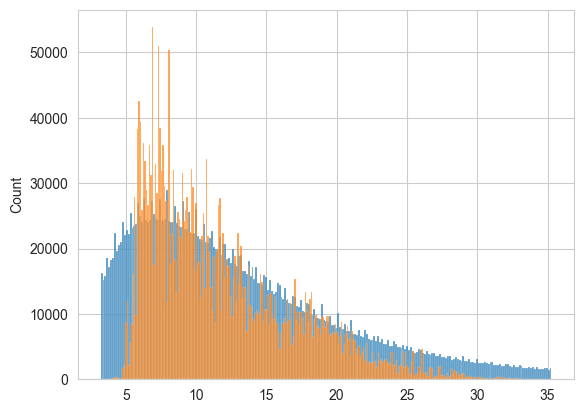

In [28]:
sns.histplot(y_validation_values, label="train")
sns.histplot(y_prediction_values, label="prediction")